Flow matching offers a different perspective on generative modeling compared to traditional normalizing flows. Instead of learning a direct invertible mapping, it learns a time-dependent vector field that transports a simple initial distribution (like a standard Gaussian) to the target data distribution.



[reference 1 cambridge intro](https://mlg.eng.cam.ac.uk/blog/2024/01/20/flow-matching.html#flow-matching)

[reference 2 flow matching guide and code](https://arxiv.org/pdf/2412.06264)

## Reqs

In [1]:
from IPython.display import clear_output
clear_output()

In [2]:
import torch, torchvision

# torch
from torch.utils.data import Dataset, DataLoader, Subset
from torch.autograd import Variable, grad
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Torchvision
from torchvision.datasets import MNIST
from torchvision import transforms as T
from torchvision import datasets, transforms, utils
import torchvision.utils as vutils

# Others
import glob, re, shutil, os, gc
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm import tqdm
from types import SimpleNamespace
from math import log, sqrt, pi
import argparse
from IPython.display import Image as IPyImage, display
import random
import time
from IPython.display import clear_output

## Helper funcs

In [3]:
class CelebLoadingData(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.images_paths = sorted(glob.glob(os.path.join(root, '*.jpg')))
        self.transforms= transforms

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, idx):
        img = Image.open(self.images_paths[idx])
        img = img.convert('RGB')
        if self.transforms: img = self.transforms(img)
        return img

In [4]:
def generate_random_samples(model, device, image_shape=(3, 128, 128), num_samples=8):
    model.eval()
    with torch.no_grad():
        # Step 1: Create dummy image to trace latent shape
        dummy_input = torch.zeros((1, *image_shape)).to(device)
        z, _ = model(dummy_input)
        latent_shape = z.shape[1:]

        # Step 2: Sample from latent space
        z_samples = torch.randn((num_samples, *latent_shape)).to(device)

        # Step 3: Invert through model
        generated, _ = model.inverse(z_samples)
        generated = generated.cpu().numpy()

        # Step 4: Plot
        fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 1.5, 2))
        for i in range(num_samples):
            img = generated[i].transpose(1, 2, 0)
            img = np.clip(img, 0.0, 1.0)
            if img.shape[2] == 1:
                img = img.squeeze(-1)
                axes[i].imshow(img, cmap='gray')
            else:
                axes[i].imshow(img)
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()

In [5]:
def visualize_reconstructions(model, dataloader, device, num_images=8):
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            images = batch

            images = images.to(device)

            # Limit to num_images
            images = images[:num_images]

            # Encode
            z, _ = model(images)

            # Decode
            recon_images, _ = model.inverse(z)

            # Move to CPU
            rimages = images.cpu().numpy()
            rrecon_images = recon_images.cpu().numpy()
            images = np.clip(rimages, 0.0, 1.0)
            recon_images = np.clip(rrecon_images, 0.0, 1.0)

            # Plot
            fig, axes = plt.subplots(2, num_images, figsize=(num_images * 1.5, 3))
            for i in range(num_images):
                img_orig = images[i].transpose(1, 2, 0)  # CHW → HWC
                img_recon = recon_images[i].transpose(1, 2, 0)

                if img_orig.shape[2] == 1:  # Grayscale (MNIST)
                    img_orig = img_orig.squeeze(-1)
                    img_recon = img_recon.squeeze(-1)
                    axes[0, i].imshow(img_orig, cmap='gray')
                    axes[1, i].imshow(img_recon, cmap='gray')
                else:  # RGB (CelebA)
                    axes[0, i].imshow(img_orig)
                    axes[1, i].imshow(img_recon)

                axes[0, i].axis('off')
                axes[1, i].axis('off')

            axes[0, 0].set_ylabel("Original", fontsize=12)
            axes[1, 0].set_ylabel("Reconstructed", fontsize=12)
            plt.tight_layout()
            plt.show()
            return rimages, rrecon_images  # Visualize only first batch

In [6]:
def flush_gpu(device=None, verbose=True):
    """
    Releases unused GPU memory by clearing cache and collecting garbage.

    Args:
        device (torch.device or int, optional): Device to flush. Defaults to current CUDA device.
        verbose (bool): If True, prints memory info before/after flushing.
    """
    if not torch.cuda.is_available():
        if verbose:
            print("CUDA is not available.")
        return

    device = device or torch.cuda.current_device()
    torch.cuda.synchronize(device)

    if verbose:
        allocated = torch.cuda.memory_allocated(device) / (1024 ** 2)
        reserved = torch.cuda.memory_reserved(device) / (1024 ** 2)
        print(f"[Before] Allocated: {allocated:.2f} MB | Reserved: {reserved:.2f} MB")

    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

    if verbose:
        allocated = torch.cuda.memory_allocated(device) / (1024 ** 2)
        reserved = torch.cuda.memory_reserved(device) / (1024 ** 2)
        print(f"[After]  Allocated: {allocated:.2f} MB | Reserved: {reserved:.2f} MB")

In [7]:
import matplotlib.pyplot as plt
import numpy as np
def show_batch(loader):
    images = next(iter(loader))
    grid = torchvision.utils.make_grid(images[:16], nrow=4, normalize=True, value_range=(-1, 1))
    npimg = grid.permute(1, 2, 0).cpu().numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(npimg)
    plt.axis('off')
    plt.title('Sample Batch from CelebA')
    plt.show()

## Data loading

In [8]:
class CelebLoadingData(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.images_paths = sorted(glob.glob(os.path.join(root, '*.jpg')))
        self.transforms= transforms

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, idx):
        img = Image.open(self.images_paths[idx])
        img = img.convert('RGB')
        if self.transforms: img = self.transforms(img)
        # img = img * 255.0 this makes them in range of 0 to 255
        return img

In [9]:
os.environ['KAGGLEHUB_CACHE'] = '/content/data'
print(device := torch.device("cuda" if torch.cuda.is_available() else "cpu"))

cuda


In [10]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("badasstechie/celebahq-resized-256x256")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/celebahq-resized-256x256


In [12]:
root = '/content/data/datasets/badasstechie/celebahq-resized-256x256/versions/1/celeba_hq_256'
root = '/kaggle/input/celebahq-resized-256x256/celeba_hq_256'

In [13]:
channels=3; size=64
transformss = T.Compose([
    T.Resize(size),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3)
])
datasett = CelebLoadingData(root, transformss)
len(datasett)
indices = list(range(30000))
subset_dataset = Subset(datasett, indices)
print(len(subset_dataset))

30000


In [15]:
print(num_worker:=os.cpu_count())

12


In [68]:
train_loader = DataLoader(subset_dataset, batch_size=256, num_workers=num_worker, persistent_workers=True, shuffle=True)

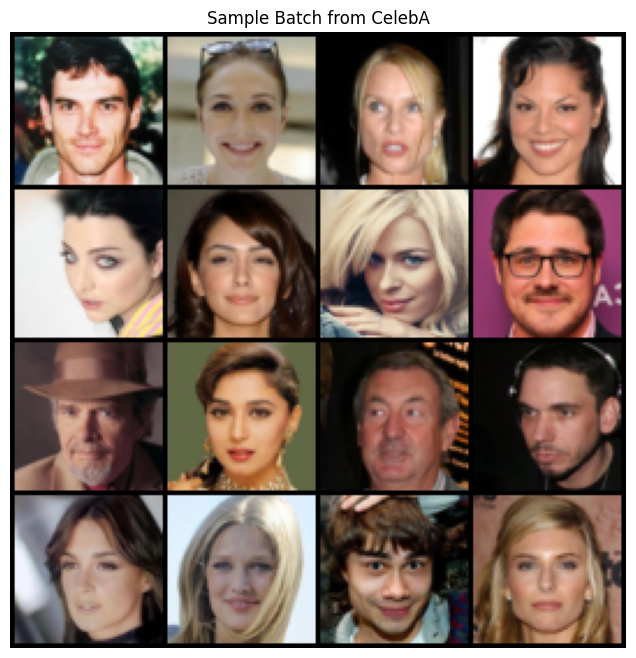

In [18]:
show_batch(train_loader)

## Model

In [17]:
# positional encoding for time input
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.linear1 = nn.Linear(1, dim)
        self.act = nn.SiLU()
        self.linear2 = nn.Linear(dim, dim)

    def forward(self, t):
        t = t.unsqueeze(-1)
        x = self.linear1(t)
        x = self.act(x)
        x = self.linear2(x)
        return x

# residual block with time embedding
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_dim=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.norm1 = nn.GroupNorm(8, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.norm2 = nn.GroupNorm(8, out_channels)
        self.act = nn.SiLU()

        self.time_embed = (
            nn.Linear(time_dim, out_channels) if time_dim is not None else None
        )

        self.skip = (
            nn.Conv2d(in_channels, out_channels, 1)
            if in_channels != out_channels
            else nn.Identity()
        )

    def forward(self, x, t=None):
        h = self.norm1(self.conv1(x))
        if self.time_embed and t is not None:
            t = self.time_embed(t).unsqueeze(-1).unsqueeze(-1)
            h = h + t
        h = self.act(h)
        h = self.norm2(self.conv2(h))
        return self.act(h + self.skip(x))

# deep U-Net with residual blocks
class FlowMatchingUNetDeep(nn.Module):
    def __init__(self, in_channels=3, base_channels=64, time_dim=256):
        super().__init__()
        self.time_embed = TimeEmbedding(time_dim)

        # encoder
        self.enc1 = ResBlock(in_channels, base_channels, time_dim)
        self.down1 = nn.Conv2d(base_channels, base_channels*2, 4, stride=2, padding=1)

        self.enc2 = ResBlock(base_channels*2, base_channels*2, time_dim)
        self.down2 = nn.Conv2d(base_channels*2, base_channels*4, 4, stride=2, padding=1)

        self.enc3 = ResBlock(base_channels*4, base_channels*4, time_dim)
        self.down3 = nn.Conv2d(base_channels*4, base_channels*8, 4, stride=2, padding=1)

        self.enc4 = ResBlock(base_channels*8, base_channels*8, time_dim)

        # bottleneck
        self.bot = ResBlock(base_channels*8, base_channels*8, time_dim)

        # decoder
        self.up3 = nn.ConvTranspose2d(base_channels*8, base_channels*4, 4, stride=2, padding=1)
        self.dec3 = ResBlock(base_channels*8, base_channels*4, time_dim)

        self.up2 = nn.ConvTranspose2d(base_channels*4, base_channels*2, 4, stride=2, padding=1)
        self.dec2 = ResBlock(base_channels*4, base_channels*2, time_dim)

        self.up1 = nn.ConvTranspose2d(base_channels*2, base_channels, 4, stride=2, padding=1)
        self.dec1 = ResBlock(base_channels*2, base_channels, time_dim)

        self.out = nn.Conv2d(base_channels, in_channels, 3, padding=1)

    def forward(self, x, t):
        t_embed = self.time_embed(t)

        # encode
        x1 = self.enc1(x, t_embed)
        x2 = self.enc2(self.down1(x1), t_embed)
        x3 = self.enc3(self.down2(x2), t_embed)
        x4 = self.enc4(self.down3(x3), t_embed)

        # bottleneck
        x_mid = self.bot(x4, t_embed)

        # decode
        x = self.dec3(torch.cat([self.up3(x_mid), x3], dim=1), t_embed)
        x = self.dec2(torch.cat([self.up2(x), x2], dim=1), t_embed)
        x = self.dec1(torch.cat([self.up1(x), x1], dim=1), t_embed)

        return self.out(x)

In [78]:
model = FlowMatchingUNetDeep().cuda()
dummy_x = torch.randn(4, 3, 64, 64).cuda()
dummy_t = torch.rand(4).cuda()
out = model(dummy_x, dummy_t)  # shape: [4, 3, 64, 64]
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [53]:
total_params = sum(p.numel() for p in model.parameters())
print(f"total parameters: {total_params:,}")

total parameters: 19,524,867


In [92]:
fixed_noise = torch.randn(12, 3, 64, 64).cuda()

## Training

In [85]:
@torch.no_grad()
def sample_and_save(
    model,
    image_size,
    device,
    step_label,
    sample_dir,
    fixed_noise=None,
    steps=50,
    num_samples=12,
    temperature=1.0,
    plot=True
):
    model.eval()

    if fixed_noise is not None:
        x = fixed_noise.clone().to(device) * temperature
    else:
        x = torch.randn(num_samples, 3, image_size, image_size, device=device) * temperature

    dt = 1.0 / steps
    for i in range(steps):
        t = torch.full((num_samples,), i * dt, device=device)
        v = model(x, t)
        x = x + v * dt

    x = x.clamp(-1, 1)
    grid = vutils.make_grid(x, nrow=4, normalize=True, value_range=(-1, 1))

    os.makedirs(sample_dir, exist_ok=True)
    path = os.path.join(sample_dir, f"sample_{step_label}.png")
    vutils.save_image(grid, path)
    # print(f"saved sample to {path}")

    if plot:
        clear_output(wait=True)
        npimg = grid.permute(1, 2, 0).cpu().numpy()
        plt.figure(figsize=(6, 6))
        plt.imshow(npimg)
        plt.axis("off")
        plt.title(f"Step {step_label}")
        plt.show()
        plt.close()


def train_flow_matching(
    model,
    dataloader,
    optimizer,
    fixed_noise,
    epochs=10,
    device="cuda",
    image_size=64,
    sample_every=1000,
    sample_dir=None,
    num_sample_images=16,
    integration_steps=50
):
    model.train()
    global_step = 0

    for epoch in range(epochs):
        pbar = tqdm.tqdm(dataloader)
        total_loss = 0

        for idx, real_imgs in enumerate(pbar):
            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)

            noise = torch.randn_like(real_imgs)
            t = torch.rand(batch_size, device=device)

            x_t = (1 - t.view(-1, 1, 1, 1)) * noise + t.view(-1, 1, 1, 1) * real_imgs
            v_target = real_imgs - noise

            v_pred = model(x_t, t)
            loss = F.mse_loss(v_pred, v_target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_description(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")

            if sample_dir and (global_step % sample_every == 0):
                step_label = f"epoch{epoch+3}_step{idx}"
                sample_and_save(
                    model=model,
                    image_size=image_size,
                    device=device,
                    fixed_noise=fixed_noise,
                    step_label=step_label,
                    sample_dir=sample_dir,
                    num_samples=num_sample_images,
                    temperature=.8,
                    plot=False
                )

            global_step += 1

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1} completed. Avg Loss: {avg_loss:.4f}")


In [89]:
epochs = 2

In [90]:
train_flow_matching(
    model=model,
    dataloader=train_loader,
    optimizer=optimizer,
    fixed_noise=fixed_noise,
    epochs=epochs,
    device='cuda',
    sample_every=50,
    sample_dir='./samples',
    num_sample_images=12,
    integration_steps=50
)

Epoch 1 | Loss: 0.1772: 100%|██████████| 118/118 [01:14<00:00,  1.58it/s]


Epoch 1 completed. Avg Loss: 0.1835


Epoch 2 | Loss: 0.1664: 100%|██████████| 118/118 [01:13<00:00,  1.61it/s]

Epoch 2 completed. Avg Loss: 0.1739


## Sampling

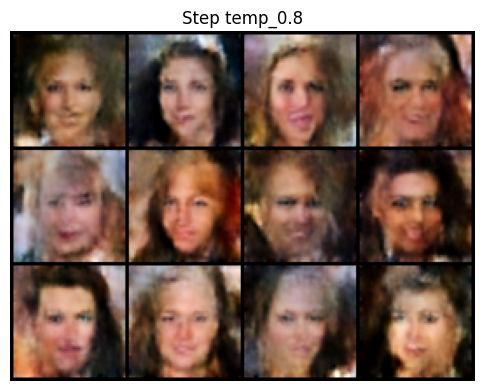

In [93]:
#@title temps
temperatures = np.linspace(0.0, .8, num=9)

for temp in temperatures:
    step_label = f"temp_{temp:.1f}"
    print(f"\nSampling with temperature = {temp:.1f}")

    sample_and_save(
        model=model,
        image_size=64,
        device='cuda',
        step_label=step_label,
        sample_dir="./temperature_sweep",
        steps=50,
        num_samples=12,
        temperature=temp,
        fixed_noise=fixed_noise,
        plot=True
    )

GIF saved to: /content/generated_samples.gif


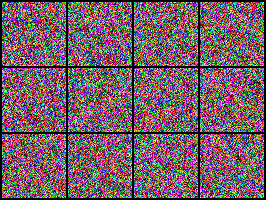

In [98]:
#@title training process second attempt
display(IPyImage(filename='/content/flow_matching/generated_samples.gif'))

In [35]:
#@title training process
display(IPyImage(filename='/content/flow_matching/flowmatching_training.gif'))

Output hidden; open in https://colab.research.google.com to view.

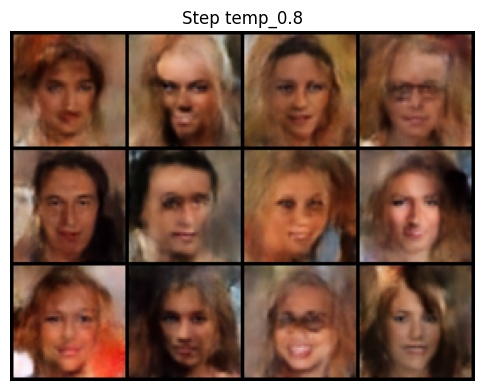

In [51]:
#@title visualization with different temps
temperatures = np.linspace(0.0, .8, num=9)

for temp in temperatures:
    step_label = f"temp_{temp:.1f}"
    print(f"\nSampling with temperature = {temp:.1f}")

    sample_and_save(
        model=model,
        image_size=64,
        device='cuda',
        step_label=step_label,
        sample_dir="./temperature_sweep",
        steps=50,
        num_samples=12,
        temperature=temp,
        fixed_noise=fixed_noise,
        plot=True
    )